In [1]:
import sys
sys.path.append('../')

import numpy as np
#from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
#from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
import scienceplots
from tensorflow.python.client import device_lib

#plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16

from tensorflow.nn import depthwise_conv2d, relu
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *
from scipy import ndimage, fft

plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

/home/liam/anaconda3/envs/lam/lib/python3.10/site-packages/skimage/filters/edges.py:2: UserWarning: A NumPy version >=1.23.5 and <2.5.0 is required for this version of SciPy (detected version 1.23.0)
  from scipy import ndimage as ndi
2025-11-01 13:05:38.541524: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-01 13:05:38.689167: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-01 13:05:38.689210: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-01 13:05:38.712723: E external/local_xla/x

#### Experiment #1 : Confirming that most energy lies within the first 3 DCT coeficients

In [2]:
model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

2025-11-01 13:05:40.173722: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-11-01 13:05:40.340598: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-11-01 13:05:40.342064: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
conv_layers = []
for l in model.layers:
    if 'conv2d' in str(type(l)).lower():
        conv_layers.append(l)


/tmp/ipykernel_10168/3156544792.py:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[l_num+1].set_xticklabels([''] * ws.shape[0])  # Set empty labels
/tmp/ipykernel_10168/3156544792.py:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[l_num+1].set_xticklabels([''] * ws.shape[0])  # Set empty labels
/tmp/ipykernel_10168/3156544792.py:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[l_num+1].set_xticklabels([''] * ws.shape[0])  # Set empty labels
/tmp/ipykernel_10168/3156544792.py:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[l_num+1].set_xticklabels([''] * ws.shape[0])  # Set empty labels
/tmp/ipykernel_10168/3156544792.py:78: UserWarni

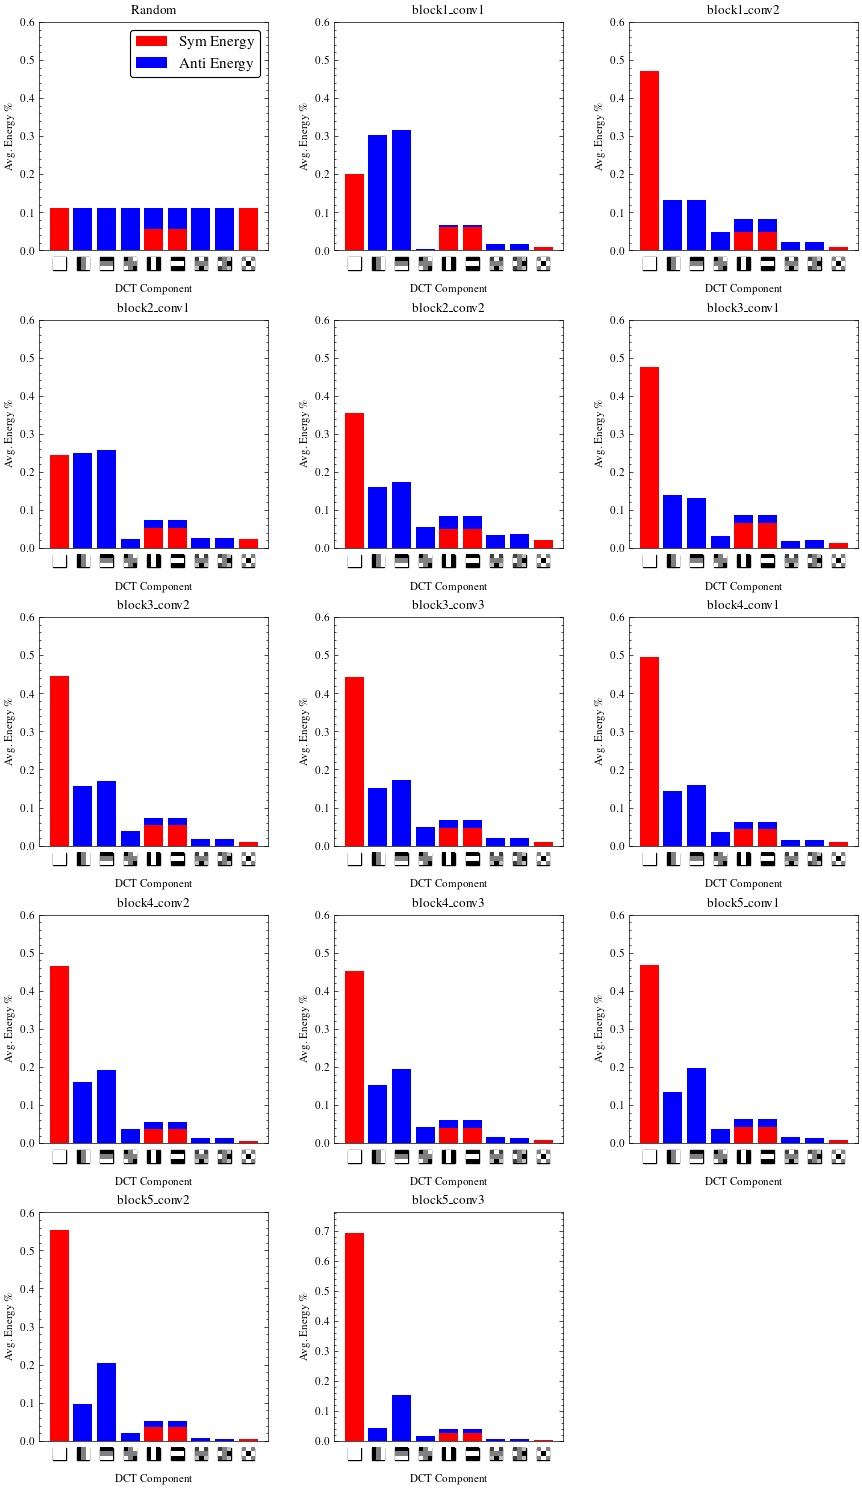

In [10]:

from matplotlib.offsetbox import OffsetImage, AnnotationBbox


#bars =  ax.bar(["dc", "c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8"], vals)
pos = [(0,0) , (0,1), (1,0), (1,1), (0, 2) , (2, 0), (1,2), (2,1), (2,2) ]

d = []
for  i,j in pos:
	t = np.zeros((3,3))
	t[i,j] =1
	d.append(tf.reshape(fft.idctn(t, norm='ortho'), (3,3,1,1)))
d = tf.cast(tf.stack(d), dtype=tf.float64)

fig,axs= plt.subplots(nrows=5, ncols=3,figsize=(9, 15))
axs = axs.ravel()

for l_num in range(-1, 13):
	
	if l_num == -1:
		f = np.random.normal(0,1, size=(3,3,100,1000)).astype('float64')
		title = "Random"
	else:
		f = get_filter(model, l_num)
		title = conv_layers[l_num].name

	f = tf.cast(f, dtype=tf.float64)

	s, a = getSymAntiSymTF(f)

	# Plot Symmetric part of filters
	ws = tf.reshape(tf.reduce_sum(s.numpy()*d, axis=(1,2)), (d.shape[0],1,1, f.shape[-2], f.shape[-1]))
	#print( tf.reduce_sum(tf.abs(ws), axis=(1,2,3,4))/tf.math.reduce_sum(tf.abs(f)))
	bars =  axs[l_num+1].bar(["dc", "c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8"], tf.reduce_sum(ws**2, axis=(1,2,3,4))/tf.math.reduce_sum(f**2), color = "r", label = r"Sym Energy")
	
	# Plot AntiSymmetric part of filters
	wa = tf.reshape(tf.reduce_sum(a.numpy()*d, axis=(1,2)), (d.shape[0],1,1, f.shape[-2], f.shape[-1]))
	bars =  axs[l_num+1].bar(["dc", "c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8"], 
						  tf.reduce_sum(wa**2, axis=(1,2,3,4))/tf.math.reduce_sum(f**2), 
						  color = "b", label=r"Anti Energy",
						  bottom=tf.reduce_sum(ws**2, axis=(1,2,3,4))/tf.math.reduce_sum(f**2))

	if l_num == -1:
		legend = axs[l_num+1].legend(
			loc='upper right',
			prop={'size': 11},
			frameon=True  # make sure the frame is drawn
		)
		frame = legend.get_frame()
		frame.set_facecolor('white')   # solid white background
		frame.set_edgecolor('black')   # black border (optional)
		frame.set_linewidth(0.8)
		frame.set_alpha(1.0)           # fully opaque

	for i, bar in enumerate(bars):
		# Load image

		dct_im = np.zeros((3,3))
		dct_im[pos[i]]=1
		#print(idct2(np.float16(dct_im)))
		img = idct2(np.float16(dct_im))

		# Create OffsetImage object
		im = OffsetImage(img, zoom=3, cmap=plt.cm.binary)  # Adjust zoom for image size

		# Get the x position of the bar's center
		x_position = bar.get_x() + bar.get_width() / 2

		# Place image below the x-axis label
		ab = AnnotationBbox(im, (x_position, 0), 
							xybox=(0, -5),  # Adjust the second value for distance under the label
							xycoords='data', 
							boxcoords="offset points", 
							pad=0, frameon=True, 
							box_alignment=(0.5, 1))

		# Add image to the axes
		axs[l_num+1].add_artist(ab)
	axs[l_num+1].set_xticklabels([''] * ws.shape[0])  # Set empty labels
	axs[l_num+1].set_xlabel('DCT Component')
	axs[l_num+1].xaxis.set_label_coords(0.5, -0.15)
	axs[l_num+1].set_ylabel('Avg. Energy \%')

	sym  = (tf.reduce_sum(ws**2, axis=(1,2,3,4)) / tf.reduce_sum(f**2)).numpy()
	anti = (tf.reduce_sum(wa**2, axis=(1,2,3,4)) / tf.reduce_sum(f**2)).numpy()
	stack = sym + anti
	axs[l_num+1].set_ylim(0, 1.10 * float(stack.max()))  # a little headroom
	axs[l_num+1].set_box_aspect(1)
	axs[l_num+1].set_title(title)

	if l_num  not in  [12, 13]:
		axs[l_num+1].set_ylim(0, 0.6)



	axs[l_num+1].tick_params(axis='x', which='both', length=0)


axs[-1].set_box_aspect(1)

fig.delaxes(axs[-1])

fig.tight_layout()
plt.savefig('vgg16_dct.pdf', dpi=600)

plt.show()

In [5]:
ws

<tf.Tensor: shape=(9, 1, 1, 512, 512), dtype=float64, numpy=
array([[[[[-1.22049451e-03,  1.93689068e-02, -3.60538829e-02, ...,
            4.70789742e-02,  4.93617598e-03, -1.41673430e-04],
          [-2.01885539e-02, -8.95908754e-03, -2.95780599e-02, ...,
            8.40557634e-03, -1.25175032e-04,  5.83296324e-03],
          [-2.30189798e-02, -1.89895428e-03, -1.22928798e-02, ...,
           -6.74940259e-03,  8.73447493e-03,  2.39687567e-02],
          ...,
          [-2.43710377e-02,  9.60242387e-03,  8.19415691e-05, ...,
           -1.44644229e-02,  1.02119423e-02, -2.03954778e-02],
          [-1.56352671e-02,  1.75324705e-03,  1.30088788e-02, ...,
           -2.46212305e-03, -3.33423464e-03, -8.12847078e-03],
          [-8.19249142e-03,  2.57111976e-02, -2.13597662e-03, ...,
           -2.00762827e-02, -1.80434485e-02, -6.93988575e-03]]]],



       [[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        

In [6]:
f = np.random.normal(0,1, size=(3,3,100,100)).astype('float64')

f = tf.cast(f, dtype=tf.float64)

s, a = getSymAntiSymTF(f)


w = tf.reshape(tf.reduce_sum(f.numpy()*d, axis=(1,2)), (d.shape[0],1,1, f.shape[-2], f.shape[-1]))
print( tf.reduce_sum(w**2, axis=(1,2,3,4))/tf.math.reduce_sum(f**2))

# Plot Symmetric part of filters

ws = tf.reshape(tf.reduce_sum(s.numpy()*d, axis=(1,2)), (d.shape[0],1,1, f.shape[-2], f.shape[-1]))
print( tf.reduce_sum(ws**2, axis=(1,2,3,4))/tf.math.reduce_sum(f**2))

# Plot AntiSymmetric part of filters
wa = tf.reshape(tf.reduce_sum(a.numpy()*d, axis=(1,2)), (d.shape[0],1,1, f.shape[-2], f.shape[-1]))
print( tf.reduce_sum(wa**2, axis=(1,2,3,4))/tf.math.reduce_sum(f**2))


print(tf.math.reduce_sum(f**2))

print(tf.math.reduce_sum(s**2) + tf.math.reduce_sum(a**2))

print(tf.math.reduce_sum(w**2))




tf.Tensor(
[0.11152685 0.10939323 0.11139052 0.11456663 0.1086958  0.110922
 0.11304938 0.11089888 0.10955671], shape=(9,), dtype=float64)
tf.Tensor(
[1.11526849e-01 1.42682929e-34 2.35159602e-34 2.84972310e-35
 5.42760010e-02 5.42760010e-02 2.26609275e-34 1.80877141e-34
 1.09556711e-01], shape=(9,), dtype=float64)
tf.Tensor(
[1.04561595e-33 1.09393235e-01 1.11390520e-01 1.14566625e-01
 5.55328977e-02 5.55328977e-02 1.13049378e-01 1.10898885e-01
 1.11734596e-33], shape=(9,), dtype=float64)
tf.Tensor(89761.20065877431, shape=(), dtype=float64)
tf.Tensor(89761.20065877431, shape=(), dtype=float64)
tf.Tensor(89761.2006587743, shape=(), dtype=float64)
